In [ ]:
!pip install torch torchvision pycocotools


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as T

# 1. Setup Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 2. Define Dataset Class
class COCODarkSpotDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        from pycocotools.coco import COCO
        from PIL import Image

        self.root_dir = root_dir
        self.transforms = transforms or T.Compose([T.ToTensor()])
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = f"{self.root_dir}/{img_info['file_name']}"

        # Load Image
        image = Image.open(img_path).convert("RGB")
        image = self.transforms(image)

        # Load Annotations
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # Only 1 class: darkspots

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        return image, target

    def __len__(self):
        return len(self.image_ids)

# 3. Dataset Paths
train_images = "/content/drive/MyDrive/DarkSpots detection.v1i.coco/train"
train_annotations = "/content/drive/MyDrive/DarkSpots detection.v1i.coco/train_annotations/_annotations.coco.json"

val_images = "/content/drive/MyDrive/DarkSpots detection.v1i.coco/valid"
val_annotations = "/content/drive/MyDrive/DarkSpots detection.v1i.coco/valid_annotations/_annotations.coco.json"

train_dataset = COCODarkSpotDataset(train_images, train_annotations)
val_dataset = COCODarkSpotDataset(val_images, val_annotations)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 4. Initialize Model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust Classifier for 2 Classes: "darkspots" + "background"
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

# 5. Training Setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

# 6. Training Function
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return total_loss / len(data_loader)

# 7. Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}")


loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 134MB/s]


Epoch 1/10, Loss: 1.4876138605177402
Epoch 2/10, Loss: 1.254257719963789
Epoch 3/10, Loss: 1.2508549466729164
Epoch 4/10, Loss: 1.2194357961416245
Epoch 5/10, Loss: 1.1825893856585026
Epoch 6/10, Loss: 1.12196708843112
Epoch 7/10, Loss: 1.0666064620018005
Epoch 8/10, Loss: 1.0681460574269295
Epoch 9/10, Loss: 1.0074763558804989
Epoch 10/10, Loss: 0.931076642125845


In [ ]:
save_path = '/content/drive/MyDrive/dark_spot_detector1.pth'  # Replace with your preferred path


In [ ]:
# Save the trained model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")


Model saved to: /content/drive/MyDrive/dark_spot_detector.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.0MB/s]
<ipython-input-2-c5acadf6f1c9>:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

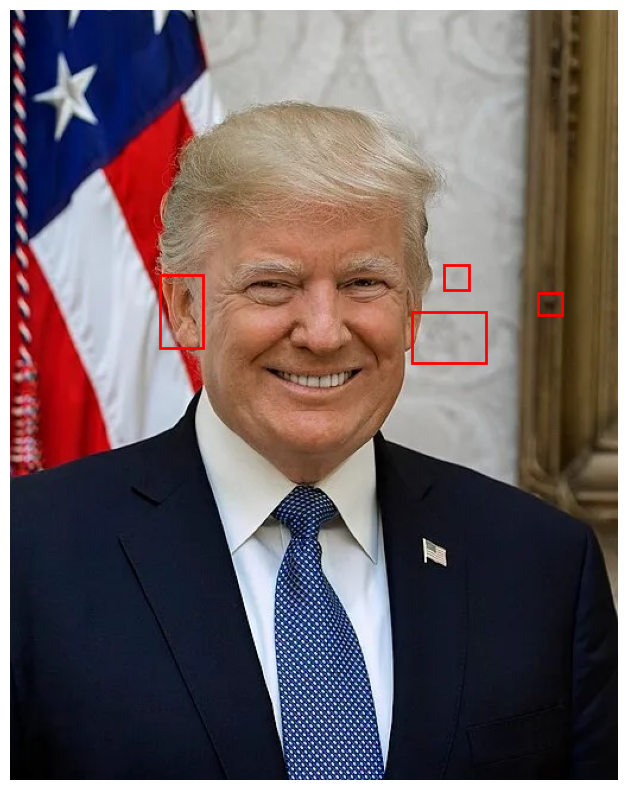

Severity Scale: 0.07831551510867643


In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import cv2
from torchvision import models, transforms


# Dark Spot Prediction Function
def predict(model, image_path, device, threshold=0.5):
    """
    Detect dark spots using a pre-trained Faster R-CNN model.
    Args:
        model: Trained Faster R-CNN model.
        image_path: Path to the input image.
        device: Device for inference (CPU or GPU).
        threshold: Confidence threshold for predictions.

    Returns:
        boxes: Filtered bounding boxes for detected spots.
        scores: Confidence scores for the detected boxes.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Extract predictions
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    boxes = boxes[scores >= threshold]  # Filter by confidence threshold
    return boxes, scores


# Visualize predictions on the image
def visualize_predictions(image_path, boxes):
    """
    Visualize bounding boxes on the image.
    Args:
        image_path: Path to the input image.
        boxes: Bounding boxes to overlay on the image.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Draw bounding boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            fill=False, color='red', linewidth=2
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


# Create a binary skin mask using DeepLab
def create_skin_mask_deeplab(image_path):
    """
    Generate a binary mask for skin regions using DeepLabV3.
    Args:
        image_path: Path to the input image.

    Returns:
        skin_mask: Binary mask where skin regions are marked as 1.
    """
    # Load pretrained DeepLabV3 model
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

    # Preprocess the image
    input_image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image).unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0)

    # Create a binary mask for class "skin"
    skin_mask = (output_predictions == 15).byte().numpy()  # Assuming class 15 represents skin
    return skin_mask


# Exclude irrelevant regions using Haar cascades
def exclude_regions(image_path, skin_mask):
    """
    Mask out non-skin regions like eyes, eyebrows, and lips using Haar cascades.
    Args:
        image_path: Path to the input image.
        skin_mask: Binary skin mask.

    Returns:
        Updated skin mask with non-skin regions masked out.
    """
    # Load Haar cascades
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

    # Load and preprocess image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]

        # Exclude eyes
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            skin_mask[ey+y:ey+eh+y, ex+x:ex+ew+x] = 0

        # Exclude mouth
        mouth = mouth_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=20)
        for (mx, my, mw, mh) in mouth:
            skin_mask[my+y:my+mh+y, mx+x:mx+mw+x] = 0

    return skin_mask


# Calculate the final severity scale
def calculate_severity(image_path, dark_spot_boxes, skin_mask, alpha=0.7, max_boxes=50):
    """
    Calculate the severity scale based on area and intensity.
    Args:
        image_path: Path to the input image.
        dark_spot_boxes: Detected bounding boxes for dark spots.
        skin_mask: Binary skin mask.
        alpha: Weight for area-based severity (default=0.7).
        max_boxes: Maximum number of spots for normalization.

    Returns:
        severity_scale: Final severity score in the range [0, 10].
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate average skin intensity
    skin_intensity = np.mean(image_gray[skin_mask == 1])

    # Calculate area-based and intensity-weighted severity
    total_area = 0
    weighted_intensity = 0
    for box in dark_spot_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        region = image_gray[y_min:y_max, x_min:x_max]
        region_mask = skin_mask[y_min:y_max, x_min:x_max]

        # Calculate region intensity and area
        spot_intensity = np.mean(region[region_mask == 1])
        area = np.sum(region_mask)

        # Weighted area based on intensity contrast
        weighted_intensity += max(0, skin_intensity - spot_intensity) * area
        total_area += area

    # Normalize severity scores
    area_severity = min(10, (total_area / np.sum(skin_mask)) * 10)
    intensity_severity = min(10, (weighted_intensity / np.sum(skin_mask)) * 10)

    # Combine area and intensity-based severity
    severity_scale = alpha * area_severity + (1 - alpha) * intensity_severity
    return severity_scale


# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dark spot detection model
dark_spot_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
dark_spot_model_path = "/content/drive/MyDrive/dark_spot_detector1.pth"
state_dict = torch.load(dark_spot_model_path, map_location=device)
dark_spot_model.load_state_dict(state_dict)
dark_spot_model.to(device)

# Input image
test_image_path = "/content/delete.jpg"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Generate and refine the skin mask
skin_mask = create_skin_mask_deeplab(test_image_path)
skin_mask = exclude_regions(test_image_path, skin_mask)

# Calculate severity scale
severity = calculate_severity(test_image_path, boxes, skin_mask)

# Visualize predictions
visualize_predictions(test_image_path, boxes)

print(f"Severity Scale: {severity}")


In [ ]:
!pip install face-parsing


using the saved model

#SCALE

<ipython-input-8-b35b8b0211d4>:206: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dark_spot_model_path, map_location=device)


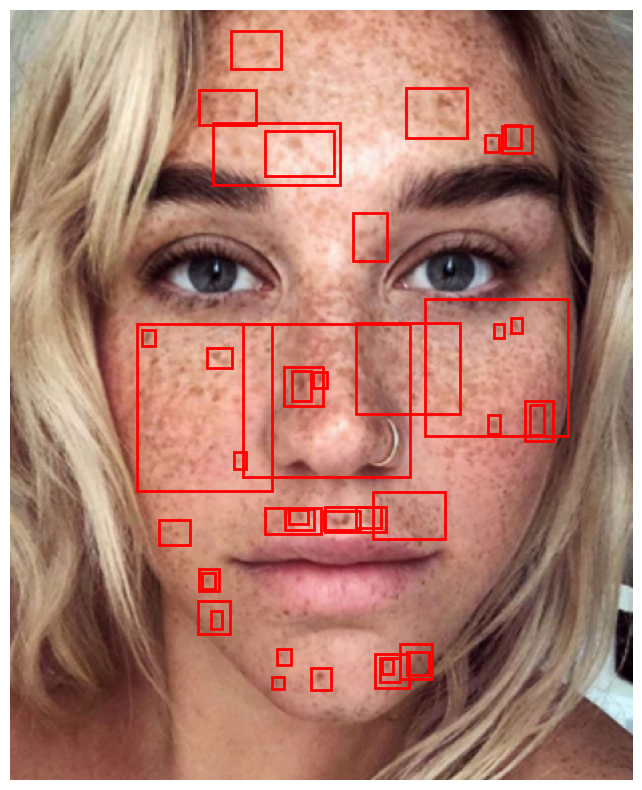

Severity Scale: 2.24 (High)


In [8]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import cv2
from torchvision import models, transforms


# Dark Spot Prediction Function
def predict(model, image_path, device, threshold=0.5):
    """
    Detect dark spots using a pre-trained Faster R-CNN model.
    Args:
        model: Trained Faster R-CNN model.
        image_path: Path to the input image.
        device: Device for inference (CPU or GPU).
        threshold: Confidence threshold for predictions.

    Returns:
        boxes: Filtered bounding boxes for detected spots.
        scores: Confidence scores for the detected boxes.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Extract predictions
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    boxes = boxes[scores >= threshold]  # Filter by confidence threshold
    return boxes, scores


# Visualize predictions on the image
def visualize_predictions(image_path, boxes):
    """
    Visualize bounding boxes on the image.
    Args:
        image_path: Path to the input image.
        boxes: Bounding boxes to overlay on the image.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Draw bounding boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            fill=False, color='red', linewidth=2
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


# Create a binary skin mask using DeepLab
def create_skin_mask_deeplab(image_path):
    """
    Generate a binary mask for skin regions using DeepLabV3.
    Args:
        image_path: Path to the input image.

    Returns:
        skin_mask: Binary mask where skin regions are marked as 1.
    """
    # Load pretrained DeepLabV3 model
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

    # Preprocess the image
    input_image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image).unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0)

    # Create a binary mask for class "skin"
    skin_mask = (output_predictions == 15).byte().numpy()  # Assuming class 15 represents skin
    return skin_mask


# Exclude irrelevant regions using Haar cascades
def exclude_regions(image_path, skin_mask):
    """
    Mask out non-skin regions like eyes, eyebrows, and lips using Haar cascades.
    Args:
        image_path: Path to the input image.
        skin_mask: Binary skin mask.

    Returns:
        Updated skin mask with non-skin regions masked out.
    """
    # Load Haar cascades
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

    # Load and preprocess image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect face
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]

        # Exclude eyes
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            skin_mask[ey+y:ey+eh+y, ex+x:ex+ew+x] = 0

        # Exclude mouth
        mouth = mouth_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=20)
        for (mx, my, mw, mh) in mouth:
            skin_mask[my+y:my+mh+y, mx+x:mx+mw+x] = 0

    return skin_mask


# Calculate the final severity scale
def calculate_severity(image_path, dark_spot_boxes, skin_mask, alpha=0.7, max_boxes=50):
    """
    Calculate the severity scale based on area and intensity.
    Args:
        image_path: Path to the input image.
        dark_spot_boxes: Detected bounding boxes for dark spots.
        skin_mask: Binary skin mask.
        alpha: Weight for area-based severity (default=0.7).
        max_boxes: Maximum number of spots for normalization.

    Returns:
        severity_scale: Final severity score in the range [0, 10].
    """
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate average skin intensity
    skin_intensity = np.mean(image_gray[skin_mask == 1])

    # Calculate area-based and intensity-weighted severity
    total_area = 0
    weighted_intensity = 0
    for box in dark_spot_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        region = image_gray[y_min:y_max, x_min:x_max]
        region_mask = skin_mask[y_min:y_max, x_min:x_max]

        # Calculate region intensity and area
        spot_intensity = np.mean(region[region_mask == 1])
        area = np.sum(region_mask)

        # Weighted area based on intensity contrast
        weighted_intensity += max(0, skin_intensity - spot_intensity) * area
        total_area += area

    # Normalize severity scores
    area_severity = min(10, (total_area / np.sum(skin_mask)) * 10)
    intensity_severity = min(10, (weighted_intensity / np.sum(skin_mask)) * 10)

    # Combine area and intensity-based severity
    severity_scale = alpha * area_severity + (1 - alpha) * intensity_severity
    return severity_scale

def classify_severity(severity):
    """
    Classify the severity scale into low, mid, and high categories.
    Args:
        severity: Calculated severity score (float).

    Returns:
        category: Severity category ("Low", "Mid", "High").
    """
    if severity <= 1:
        return "Low"
    elif 1 < severity <= 2:
        return "Mid"
    else:
        return "High"

# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dark spot detection model
dark_spot_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
dark_spot_model_path = "/content/drive/MyDrive/dark_spot_detector1.pth"
state_dict = torch.load(dark_spot_model_path, map_location=device)
dark_spot_model.load_state_dict(state_dict)
dark_spot_model.to(device)

# Input image
test_image_path = "/content/Screenshot 2024-12-20 101859.png"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Generate and refine the skin mask
skin_mask = create_skin_mask_deeplab(test_image_path)
skin_mask = exclude_regions(test_image_path, skin_mask)

# Calculate severity scale
severity = calculate_severity(test_image_path, boxes, skin_mask)

# Classify the severity
severity_category = classify_severity(severity)

# Visualize predictions
visualize_predictions(test_image_path, boxes)

print(f"Severity Scale: {severity:.2f} ({severity_category})")


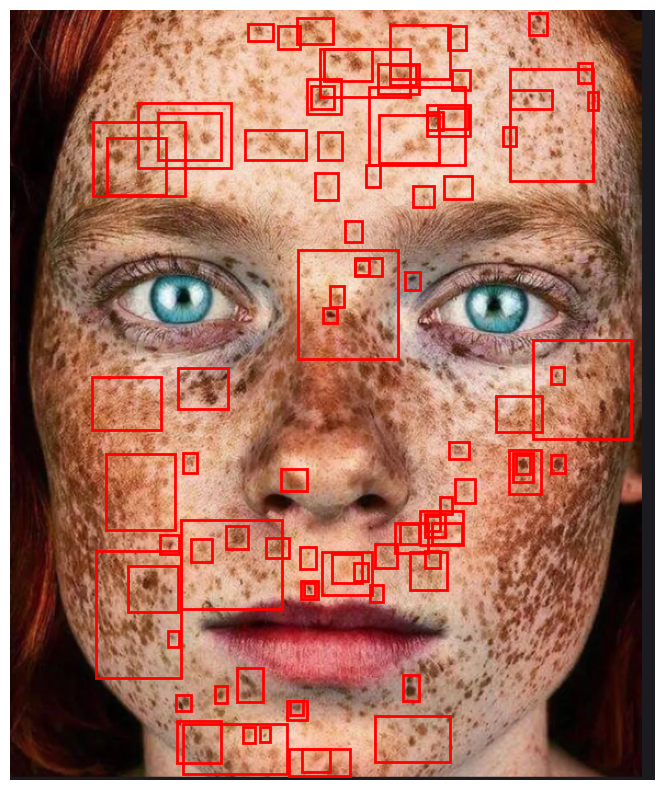

Severity Scale: 2.44 (High)


In [9]:
# Input image
test_image_path = "/content/Screenshot 2024-12-27 222543.png"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Generate and refine the skin mask
skin_mask = create_skin_mask_deeplab(test_image_path)
skin_mask = exclude_regions(test_image_path, skin_mask)

# Calculate severity scale
severity = calculate_severity(test_image_path, boxes, skin_mask)
# Classify the severity
severity_category = classify_severity(severity)

# Visualize predictions
visualize_predictions(test_image_path, boxes)

print(f"Severity Scale: {severity:.2f} ({severity_category})")



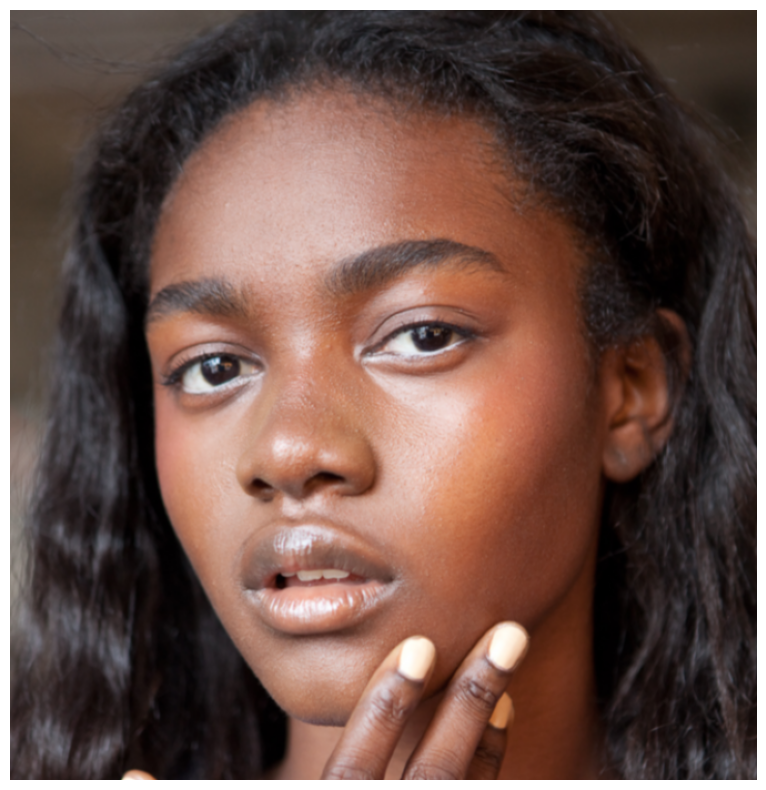

Severity Scale: 0.00 (Low)


In [10]:
# Input image
test_image_path = "/content/Screenshot 2024-12-20 095122.png"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Generate and refine the skin mask
skin_mask = create_skin_mask_deeplab(test_image_path)
skin_mask = exclude_regions(test_image_path, skin_mask)

# Calculate severity scale
severity = calculate_severity(test_image_path, boxes, skin_mask)

# Classify the severity
severity_category = classify_severity(severity)

# Visualize predictions
visualize_predictions(test_image_path, boxes)

print(f"Severity Scale: {severity:.2f} ({severity_category})")

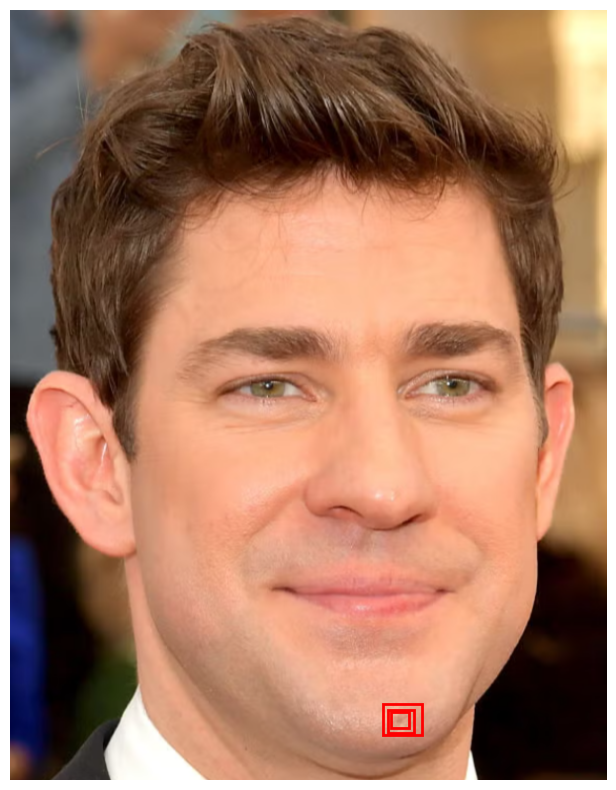

Severity Scale: 0.05 (Low)


In [13]:
# Input image
test_image_path = "/content/Screenshot 2024-12-20 094951.png"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Generate and refine the skin mask
skin_mask = create_skin_mask_deeplab(test_image_path)
skin_mask = exclude_regions(test_image_path, skin_mask)

# Calculate severity scale
severity = calculate_severity(test_image_path, boxes, skin_mask)

# Classify the severity
severity_category = classify_severity(severity)

# Visualize predictions
visualize_predictions(test_image_path, boxes)

print(f"Severity Scale: {severity:.2f} ({severity_category})")

#Improving this by trying to get density


<ipython-input-3-d97c87faebd0>:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dark_spot_model_path, map_location=device)


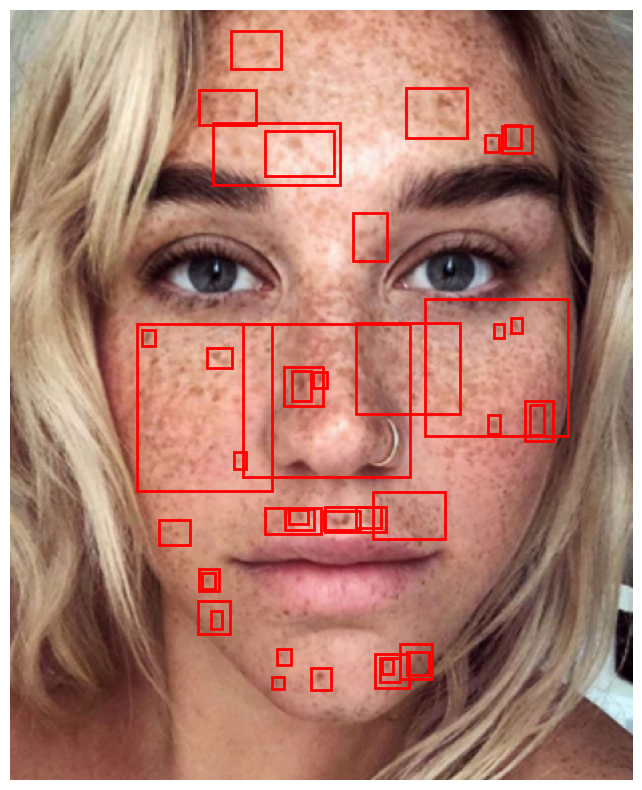

Dark Spots Detected in the Following Regions:
  - Forehead: 8 spot(s) detected
  - Left_cheek: 7 spot(s) detected
  - Right_cheek: 11 spot(s) detected
  - Chin: 10 spot(s) detected


In [3]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import cv2
from torchvision import models, transforms


# Dark Spot Prediction Function
def predict(model, image_path, device, threshold=0.5):
    """
    Detect dark spots using a pre-trained Faster R-CNN model.
    Args:
        model: Trained Faster R-CNN model.
        image_path: Path to the input image.
        device: Device for inference (CPU or GPU).
        threshold: Confidence threshold for predictions.

    Returns:
        boxes: Filtered bounding boxes for detected spots.
        scores: Confidence scores for the detected boxes.
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Extract predictions
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    boxes = boxes[scores >= threshold]  # Filter by confidence threshold
    return boxes, scores


# Divide the face into regions
def define_face_regions(face_box):
    """
    Define regions of the face (left cheek, right cheek, forehead, chin).
    Args:
        face_box: Coordinates of the detected face bounding box.

    Returns:
        regions: Dictionary with predefined face regions and their bounding boxes.
    """
    x_min, y_min, x_max, y_max = face_box
    width = x_max - x_min
    height = y_max - y_min

    regions = {
        "forehead": (x_min, y_min, x_max, y_min + int(height * 0.3)),
        "left_cheek": (x_min, y_min + int(height * 0.3), x_min + int(width * 0.5), y_max - int(height * 0.2)),
        "right_cheek": (x_min + int(width * 0.5), y_min + int(height * 0.3), x_max, y_max - int(height * 0.2)),
        "chin": (x_min, y_max - int(height * 0.2), x_max, y_max),
    }
    return regions


# Determine where dark spots are detected
def detect_regions_with_dark_spots(boxes, face_regions):
    """
    Identify which face regions contain dark spots.
    Args:
        boxes: Detected bounding boxes for dark spots.
        face_regions: Dictionary of face region bounding boxes.

    Returns:
        region_counts: Dictionary indicating the number of spots in each region.
    """
    region_counts = {region: 0 for region in face_regions.keys()}

    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)

        for region, (rx_min, ry_min, rx_max, ry_max) in face_regions.items():
            # Check if the dark spot box intersects with the region box
            if (
                x_min < rx_max and x_max > rx_min and
                y_min < ry_max and y_max > ry_min
            ):
                region_counts[region] += 1

    return region_counts


# Visualize predictions on the image
def visualize_predictions(image_path, boxes):
    """
    Visualize bounding boxes on the image.
    Args:
        image_path: Path to the input image.
        boxes: Bounding boxes to overlay on the image.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Draw bounding boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            fill=False, color='red', linewidth=2
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dark spot detection model
dark_spot_model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
dark_spot_model_path = "/content/drive/MyDrive/dark_spot_detector1.pth"
state_dict = torch.load(dark_spot_model_path, map_location=device)
dark_spot_model.load_state_dict(state_dict)
dark_spot_model.to(device)

# Input image
test_image_path = "/content/Screenshot 2024-12-20 101859.png"

# Predict dark spots
boxes, scores = predict(dark_spot_model, test_image_path, device)

# Detect face and divide into regions
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
image = cv2.imread(test_image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

if len(faces) > 0:
    face_box = faces[0]  # Assuming one face in the image
    face_regions = define_face_regions(face_box)

    # Detect regions with dark spots
    region_counts = detect_regions_with_dark_spots(boxes, face_regions)

    # Visualize predictions
    visualize_predictions(test_image_path, boxes)

    # Print detected regions
    print("Dark Spots Detected in the Following Regions:")
    for region, count in region_counts.items():
        if count > 0:
            print(f"  - {region.capitalize()}: {count} spot(s) detected")
    # Find the region with the most dark spots (based on area)
    most_affected_region = max(region_areas, key=region_areas.get)
    print(f"\nThe region with the most dark spots is: {most_affected_region.capitalize()}")
else:
    print("No face detected in the image.")



